In [1]:
# % Fig 5: fine-tuning metaparameters of "iterations" 
# % 	- batch size effect on the iterations performance
# % 	- add/noadd & different ranking schemes effect
# % 	- comparison  of the best model with with docking-as-predictor
# % 	- TODO: comparison with the really best single model

# % How did we come up with iterations scheme:
# % 	- compared different train sizes
# % 	- compared different regimes (add/noadd)
# % 	- compared different ensembling methods
# % 	- compare with "docking-as-predictor"


In [3]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tqdm.notebook import tqdm

In [25]:
%%time

datasets = {
    'AmpC':'../data/AmpC_screen_table_1M/result_iterations_Morgan_size=2048_radius=2.csv',
    'D4'  :'../data/D4_screen_table_1M/result_iterations_Morgan_size=2048_radius=2.csv'
           }
dataset_size = {'AmpC':96214206, 'D4':138312677}

dfs = []
for name, path in tqdm(datasets.items()):
    df = pd.read_csv(path)
    df['proj'] = name
    df['N_ligands'] = dataset_size.get(name)
    dfs.append(df)

raw_data = pd.concat(dfs)

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 4.57 s, sys: 652 ms, total: 5.23 s
Wall time: 5.21 s


In [6]:
raw_data.prediction_method.unique()

array(['MeanRank', 'LastModel', 'TopFromEveryModel'], dtype=object)

In [8]:
raw_data.model.unique()

array(['LinearRegression', 'DecisionTreeClassifier'], dtype=object)

In [11]:
raw_data.add_to_train.unique()

array(['add', 'noadd', 'True', 'False'], dtype=object)

In [59]:
df = (raw_data
      .reset_index()
      .replace({
        'add':'True',
        'noadd':'False'
      })
#       .query("add_to_train == 'False'")
#       .query("prediction_method == 'MeanRank'")
      .assign(model_and_proj = lambda df: df.proj + '_' + df.model)
#       .query("proj == 'D4'")
)


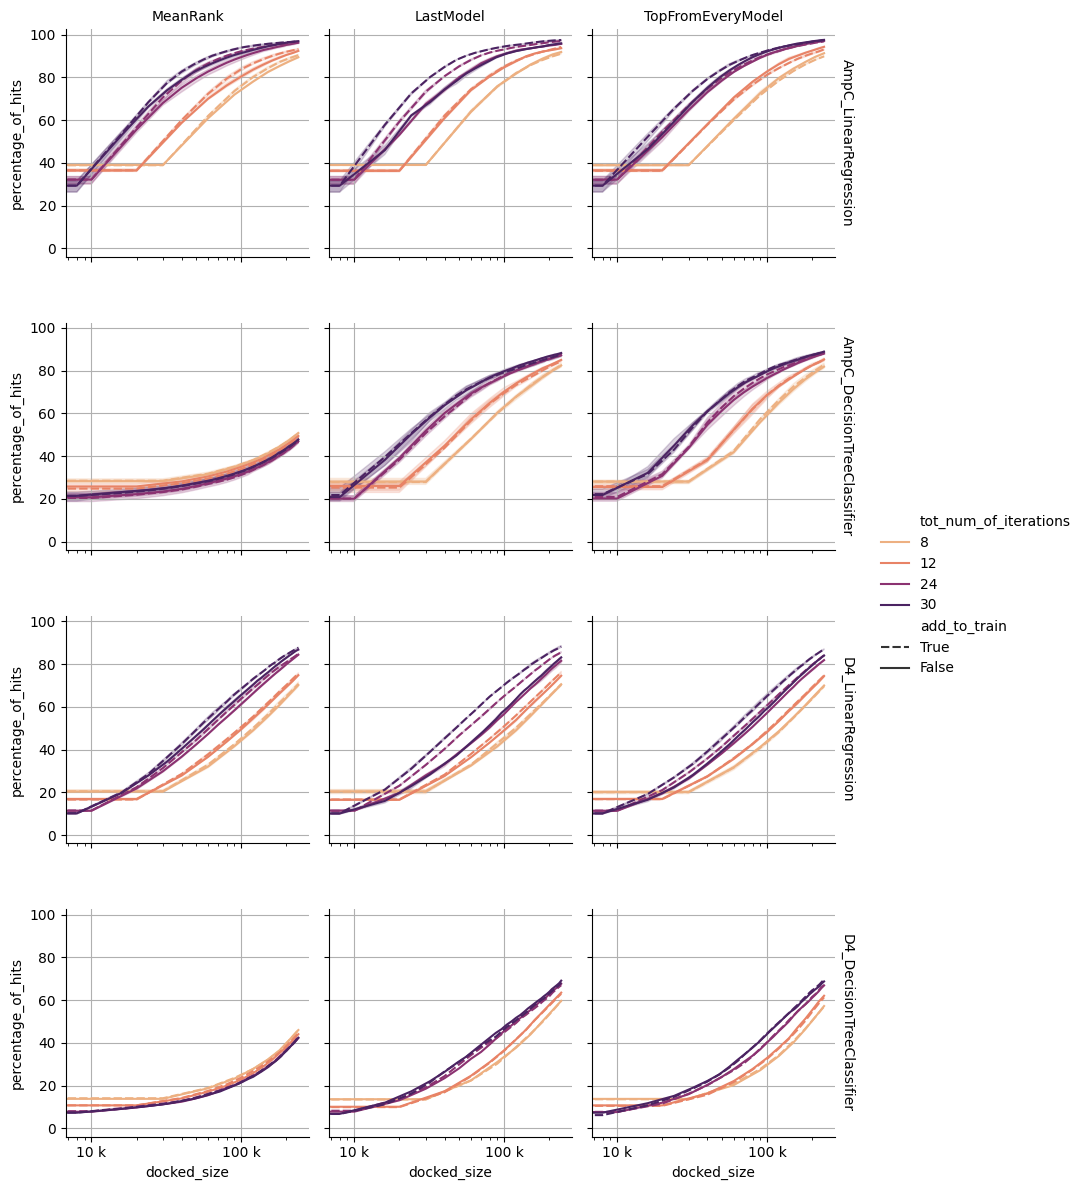

In [70]:
kwa = {
    'x': 'docked_size',
    'y': "percentage_of_hits", 
    'hue': "tot_num_of_iterations",
    'style':'add_to_train'
}

grid = sns.FacetGrid(df, 
                     row = "model_and_proj", 
                     col = "prediction_method",
                     margin_titles=True
                    )
(grid
 .map_dataframe(sns.lineplot, **kwa, palette='flare')
 .set(xscale = 'log')
)

for ax in grid.axes.flat:
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.grid()
#     ax.set_xlim(1,None)
#     plt.setp(ax.get_yticklabels(), rotation=90)


grid.set_titles(row_template = '{row_name}', col_template = '{col_name}')
grid.add_legend()

plt.savefig('../figures/Figure_3.png')
plt.show()